In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import essential libraries (for data processing, visualization, and modeling)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")   # Code to suppress warning messages

# Import sklearn modules related to model training and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting, hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder     # Normalization, categorical encoding
from sklearn.compose import ColumnTransformer   # Separate processing for numerical and categorical features
from sklearn.pipeline import Pipeline   # Build processing and modeling pipeline
from sklearn.impute import SimpleImputer    # Handle missing values
from sklearn.ensemble import RandomForestClassifier     # Random Forest model

# Model performance evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# sklearn setting: Enable automatic naming of parameter keys in pipeline
from sklearn import set_config
set_config(enable_metadata_routing=True)


1. Select columns for preprocessing and handle missing values.

In [3]:
# 1. Load CSV file ('wine.csv' is loaded as a pandas DataFrame)
df = pd.read_csv("wine.csv")

# Print the shape of the full dataset → Check the original number of samples and features
print("📦 Original dataset shape:", df.shape)

# Randomly sample 1/10 of the entire dataset
# To reduce training time as the full dataset is too large
df = df.sample(frac=0.1, random_state=42).copy()

# 2. Select relevant columns
# Extract only the necessary columns for analysis
cols = ['category', 'designation', 'appellation', 'alcohol', 'price', 'rating', 'varietal']
df = df[cols].copy()

# 3. Preprocess alcohol column (remove '%' and convert to numeric)
# Remove '%' symbol from string values in 'alcohol' column
# Convert string to float, and handle non-numeric values as NaN
df['alcohol'] = df['alcohol'].astype(str).str.replace('%', '', regex=False)
df['alcohol'] = pd.to_numeric(df['alcohol'], errors='coerce')

# 4. Preprocess price column (remove symbols like '$' and convert to numeric)
# Remove '$', commas, etc. from 'price' column to extract numbers
df['price'] = df['price'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 5. Remove missing values
# Drop rows that contain NaN values either from the above conversions or originally existing
# Remove rows with missing values in key analysis columns
df.dropna(subset=cols, inplace=True)

print("✅ Dataset shape after missing value handling:", df.shape)


📦 Original data size: (323237, 11)
✅ Data size after handling missing values: (17405, 7)


2. Categorical Variable Encoding + Numerical Variable Scaling

In [4]:
# 1. Separate X and y
# Split input features (X) and target variable (y)
# 'varietal' is the wine variety to be predicted -> set as y
X = df.drop('varietal', axis=1)
y = df['varietal']

# 2. Separate feature types
# Separate numerical and categorical features for different preprocessing strategies
num_features = ['alcohol', 'price', 'rating']  # Numerical columns
cat_features = ['category', 'designation', 'appellation']  # Categorical columns

# 3. Numerical: Impute missing values with mean + Standardization
# Fill missing values with the mean
# StandardScaler: Normalize data to mean 0, std 1 to stabilize model training
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 4. Categorical: Impute missing values with most frequent + One-Hot Encoding
# Fill missing values with the most frequent value (mode)
# Use OneHotEncoder to convert strings into binary vectors usable by the model
# 'handle_unknown = ignore' skips unseen categories during inference
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 5. Combine preprocessing
# Use ColumnTransformer to combine numeric and categorical pipelines
# Automatically applies the respective pipeline to specified feature types
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),  # Numerical pipeline
    ('cat', cat_transformer, cat_features)   # Categorical pipeline
])

print("✅ Encoding and scaling pipeline setup complete")


✅ Encoding and scaling pipeline setup complete


3. Simple EDA Visualization (Distributions of Numerical & Categorical Features)

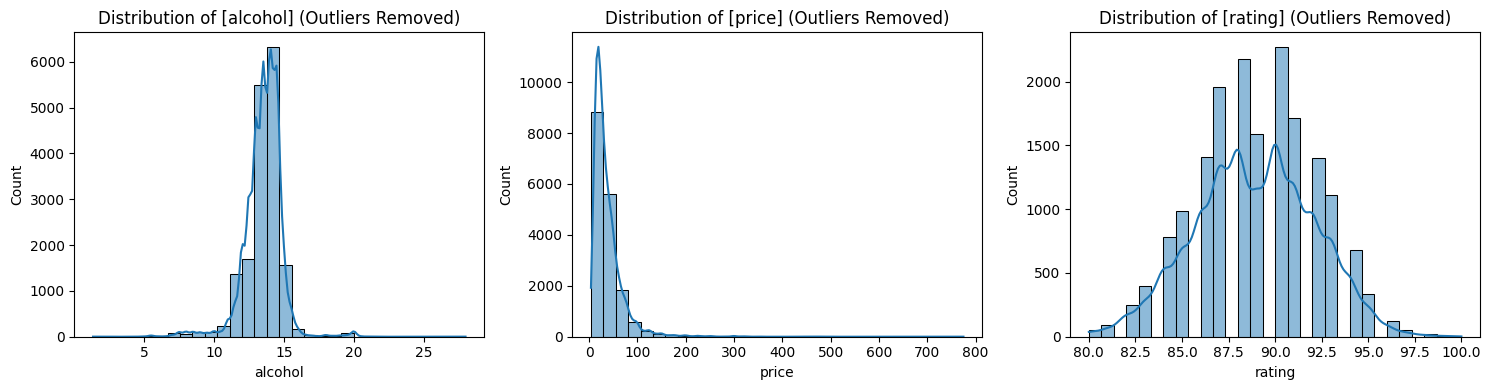

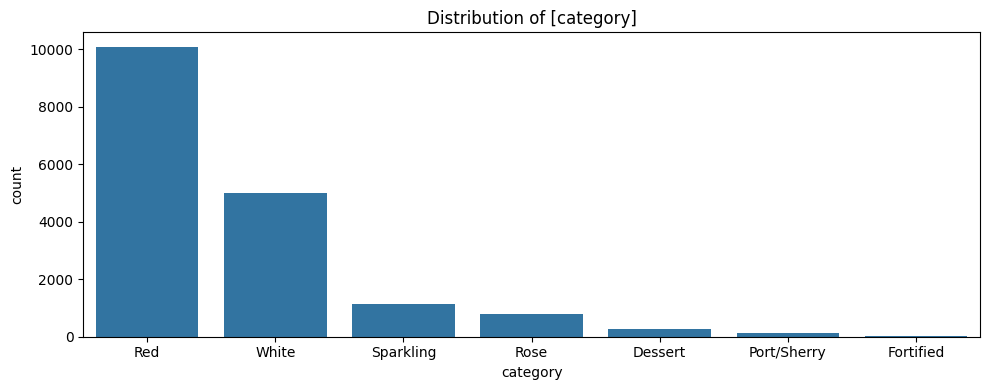

In [5]:
# Create a copy for visualization and filter out outliers
df_viz = df.copy()  # Create a copy to avoid modifying the original dataset

# Remove outliers: filter out rows where alcohol >= 30 or price >= 1000 (to make the visualization cleaner)
df_viz = df_viz[(df_viz['alcohol'] < 30) & (df_viz['price'] < 1000)]

# Visualize the distribution of numerical features
plt.figure(figsize=(15, 4))  # Set a wide figure size for side-by-side plots
for i, col in enumerate(['alcohol', 'price', 'rating']):  # Iterate over numerical features
    plt.subplot(1, 3, i+1)  # Place in 1 row, 3 columns layout (position i+1)
    sns.histplot(df_viz[col], bins=30, kde=True)  # Plot histogram with KDE curve
    plt.title(f"Distribution of [{col}] (Outliers Removed)")
plt.tight_layout()  # Automatically adjust spacing between plots
plt.show()

# Visualize the distribution of the categorical feature (category)
plt.figure(figsize=(10, 4))  # Set a wider figure size for category distribution

# Create a countplot ordered by frequency of each category
sns.countplot(data=df_viz, x='category', order=df_viz['category'].value_counts().index)
plt.title("Distribution of [category]")
plt.tight_layout()
plt.show()


4. Select at least two classification models for comparison.

In [6]:
from sklearn.linear_model import LogisticRegression

# Keep only varietal classes that appear at least twice
# This avoids model training issues due to classes with too few samples
y_counts = df['varietal'].value_counts()  # Count samples per class
valid_classes = y_counts[y_counts >= 2].index  # Keep only classes with 2 or more samples
df_filtered = df[df['varietal'].isin(valid_classes)].copy()  # Filter the dataset by valid classes

# Separate X and y
# All columns except 'varietal' are used as input features X
X = df_filtered.drop('varietal', axis=1)
y = df_filtered['varietal']  # Target variable y

print("✅ Dataset size after filtering valid classes:", X.shape)

# Split data into training and testing sets (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


✅ Dataset size after filtering valid classes: (17294, 6)


5. Use Preprocessing Pipeline + Model Training and Evaluation

In [7]:
# Iterate over the defined models and perform training/prediction/evaluation for each
for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    
    # Construct the full pipeline
    # Combine the preprocessor and classifier into a single pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Pipeline that includes preprocessing for numerical/categorical data
        ('classifier', model)  # Insert model (Logistic Regression, Random Forest, etc.)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)  # Train using the training data

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Print performance evaluation metrics
    print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision : {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall    : {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1 Score  : {f1_score(y_test, y_pred, average='macro'):.4f}")



🔍 Model: Logistic Regression
Accuracy  : 0.6256
Precision : 0.2426
Recall    : 0.1877
F1 Score  : 0.2016

🔍 Model: Random Forest
Accuracy  : 0.6331
Precision : 0.3500
Recall    : 0.2957
F1 Score  : 0.3068


6. Performance Evaluation


🔍 Model: Logistic Regression
                                                     precision    recall  f1-score   support

                             Agiorgitiko, Greek Red       0.00      0.00      0.00         2
                             Aglianico, Italian Red       1.00      0.50      0.67         8
                                           Albariño       0.67      0.36      0.47        11
                        Alfrocheiro, Portuguese Red       0.00      0.00      0.00         1
                       Alicante Bouschet, Other Red       0.00      0.00      0.00         2
                               Aligoté, Other White       0.00      0.00      0.00         1
                    Alsace white blend, White Blend       0.00      0.00      0.00         3
                                Alvarinho, Albariño       0.50      0.25      0.33         4
                        Antão Vaz, Portuguese White       0.00      0.00      0.00         1
                           Arinto, Port

<Figure size 1000x800 with 0 Axes>

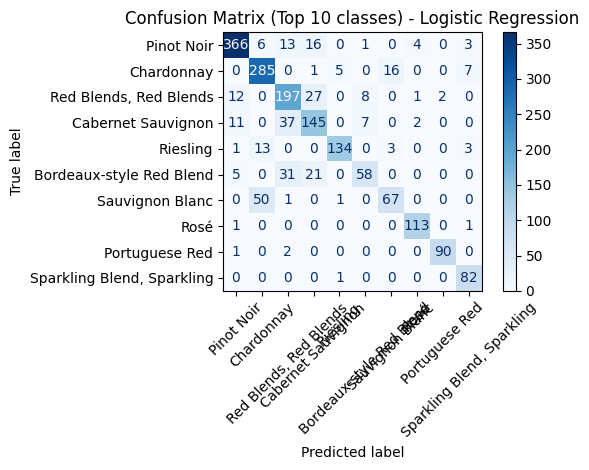


🔍 Model: Random Forest
                                                     precision    recall  f1-score   support

                             Agiorgitiko, Greek Red       0.00      0.00      0.00         2
                             Aglianico, Italian Red       1.00      0.62      0.77         8
                                           Albariño       0.67      0.36      0.47        11
                        Alfrocheiro, Portuguese Red       0.00      0.00      0.00         1
                       Alicante Bouschet, Other Red       1.00      0.50      0.67         2
                               Aligoté, Other White       0.00      0.00      0.00         1
                    Alsace white blend, White Blend       1.00      0.33      0.50         3
                                Alvarinho, Albariño       0.50      0.50      0.50         4
                        Antão Vaz, Portuguese White       0.00      0.00      0.00         1
                           Arinto, Portuguese

<Figure size 1000x800 with 0 Axes>

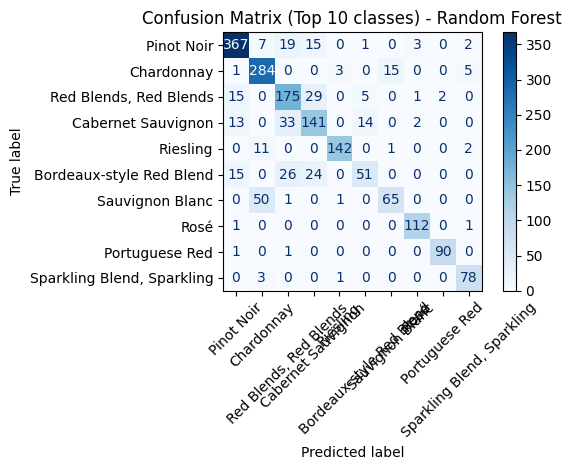

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluation for all classes
for name, model in models.items():
    # 1. Build pipeline (preprocessor + classifier)
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # 2. Train and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 3. Print performance evaluation report
    print(f"\n🔍 Model: {name}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Visualize confusion matrix for top 10 classes only
    top_10_labels = y.value_counts().index[:10]  # Select the top 10 classes with most samples
    mask = y_test.isin(top_10_labels)  # Filter test set to include only top 10 classes
    y_test_top = y_test[mask]  # Actual labels for the top 10 classes
    y_pred_top = pd.Series(y_pred, index=y_test.index)[mask]  # Predicted labels for the same indices

    # 4. Compute and create confusion matrix display object
    cm = confusion_matrix(y_test_top, y_pred_top, labels=top_10_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_10_labels)

    # 5. Display visualization
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix (Top 10 classes) - {name}")
    plt.tight_layout()
    plt.show()


7. Define Parameters for Tuning and Run GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV
import time

# Set the hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [50, 100],  # Number of trees
    'classifier__max_depth': [None, 10, 20],  # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5]  # Minimum number of samples to split an internal node
}

# Create pipeline for Random Forest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Redefine preprocessing
num_features = ['alcohol', 'price', 'rating']
cat_features = ['category', 'designation', 'appellation']

# Numerical features: impute with mean + standard scaling
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical features: impute with most frequent + one-hot encoding
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Complete pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Start tuning
start = time.time()

# Define GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit model
grid_search.fit(X_train, y_train)
end = time.time()

print(f"\nTuning complete! Time taken: {round(end - start, 2)} seconds")
print("Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Tuning complete! Time taken: 113.55 seconds
Best hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


8. Evaluation of the Tuned Model

In [10]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
# Use the tuned model (grid_search) to generate predictions on the test set 
y_pred_tuned = grid_search.predict(X_test)

# Performance evaluation
# Accuracy 
acc = accuracy_score(y_test, y_pred_tuned)

# Precision - weighted average across classes; handle division by zero as 0 
prec = precision_score(y_test, y_pred_tuned, average='weighted', zero_division=0)

# Recall - weighted average across classes 
rec = recall_score(y_test, y_pred_tuned, average='weighted', zero_division=0)

# F1 Score - harmonic mean of precision and recall (weighted average) 
f1 = f1_score(y_test, y_pred_tuned, average='weighted', zero_division=0)

# Print results 
print("\n✅ [Performance Evaluation After Tuning]")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")



✅ [Performance Evaluation After Tuning]
Accuracy : 0.6317
Precision: 0.6067
Recall   : 0.6317
F1 Score : 0.5991


9. Confusion Matrix (After Tuning)

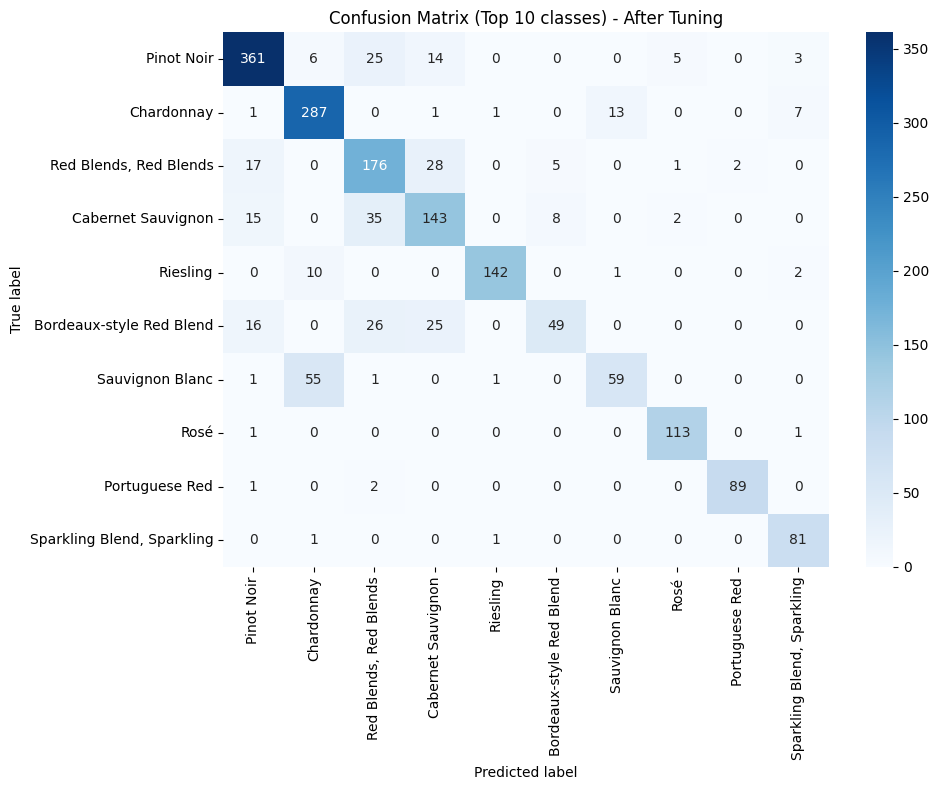

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Visualize only the top 10 most frequent classes
top_classes = y_test.value_counts().head(10).index  # Extract top 10 most frequent classes
mask = y_test.isin(top_classes)  # Select data belonging only to those classes

# Improved Confusion Matrix
# Select only the top 10 classes from both predictions and actual values
# Align predicted values using pd.Series with the correct index
cm = confusion_matrix(y_test[mask], pd.Series(y_pred_tuned, index=y_test.index)[mask], labels=top_classes)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_classes, yticklabels=top_classes)
plt.title("Confusion Matrix (Top 10 classes) - After Tuning")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()
